In [209]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import RegularGridInterpolator

In [210]:
def integrate_particles(positions, concentrations, velocity_field, X, Y, dt, num_steps, L, phase_field, gamma, r):
    num_particles = len(positions)
    positions_over_time,  concentrations_over_time = np.zeros((num_steps+1, num_particles, 2)), np.zeros((num_steps+1, num_particles, 1))
    positions_over_time[0] = positions
    concentrations_over_time[0] = concentrations
    negpsiy, psix = -1*diff_wrt_y(velocity_field), diff_wrt_x(velocity_field)
    phix, phiy = diff_wrt_x(phase_field), diff_wrt_y(phase_field)
    interpsiy, interphix, interpsix, interphiy = interpolate(negpsiy), interpolate(phix), interpolate(psix), interpolate(phiy)
    t = [i*dt for i in range(num_steps+1)]
    psiyx, psixy = diff_wrt_x(negpsiy), diff_wrt_y(psix)
    phixx, phiyy = diff_wrt_x(phix), diff_wrt_y(phiy)
    interpsiyx, interphixx, interpsixy, interphiyy = interpolate(psiyx), interpolate(phixx), interpolate(psixy), interpolate(phiyy)
    a = [interpsiy, interphix, interpsix, interphiy, interpsiyx, interphixx, interpsixy, interphiyy]
    answer = new_vector_rk4(fun, t, polynomial_u, polynomial_v, positions_over_time, polynomial_du, polynomial_dv, concentrations_over_time, num_particles, a)
    return answer

def polynomial_u(coords, a):
    interpsiy, interphix = a[0], a[1]
    return np.real((1-gamma)*interpsiy(coords)+gamma*interphix(coords))

def polynomial_v(coords, a):
    #print(coords)
    interpsix, interphiy = a[2], a[3]
    return np.real((1-gamma)*interpsix(coords)+gamma*interphiy(coords))

def polynomial_du(coords, a):
    interpsiyx, interphixx = a[4], a[5]
    return np.real((1-gamma)*interpsiyx(coords)+gamma*interphixx(coords))

def polynomial_dv(coords, a):
    interpsixy, interphiyy = a[6], a[7]
    return np.real((1-gamma)*interpsixy(coords)+gamma*interphiyy(coords))

def diff_wrt_y(original_matrix): 
    nt, nx, ny = original_matrix.shape
    umatrix = np.copy(original_matrix)
    for i in range(nt):
        umatrix[i] = np.gradient(original_matrix[i], axis=1) 
    #print(umatrix)
    return umatrix

def diff_wrt_x(original_matrix):
    vmatrix = np.copy(original_matrix)
    nt, nx, ny = original_matrix.shape
    for i in range(nt):
        vmatrix[i] = np.gradient(original_matrix[i], axis=0) 
    return vmatrix

def interpolate(umatrix):

    t = umatrix.shape[0]
    time = [i*r for i in range(t)] #gives time in days *r
    #print(time)
    interpolator = RegularGridInterpolator((time, X, Y), umatrix, method = "quintic")
    #print("interpolator")
    #print((time, X, Y))
    return interpolator

def new_vector_rk4(f, t, polynomial_u, polynomial_v, positions_over_time, polynomial_du, polynomial_dv, concentrations_over_time, num_particles, a):
    n = len(t)
    y = np.concatenate((positions_over_time, concentrations_over_time), axis=2)

    for i in range(n - 1):
        h = t[i+1] - t[i]
        k1 = f(t[i], y[i], polynomial_u, polynomial_v, polynomial_du, polynomial_dv, num_particles, a)
        k2 = f(t[i] + 0.5*h, (y[i] + 0.5*h*k1) % (2*L), polynomial_u, polynomial_v, polynomial_du, polynomial_dv, num_particles, a)
        k3 = f(t[i] + 0.5*h, (y[i] + 0.5*h*k2) % (2*L), polynomial_u, polynomial_v, polynomial_du, polynomial_dv, num_particles, a)
        k4 = f(t[i+1], (y[i] + h*k3) % (2*L), polynomial_u, polynomial_v, polynomial_du, polynomial_dv, num_particles, a)
        y[i+1] = y[i] + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
    return np.mod(y, 2*L)

def fun(t, y, polynomial_u, polynomial_v, polynomial_du, polynomial_dv, num_particles, a):
    xlist, ylist, conclist = [i % (2*L) for i in y[:, 0]], [i % (2*L)  for i in y[:, 1]], [i % (2*L)  for i in y[:, 2]] 
    timecoords = t*np.ones(num_particles)
    coords = [[x, y, z] for x, y, z in zip(timecoords, xlist, ylist)]
    dxdt, dydt = polynomial_u(coords, a), polynomial_v(coords, a)
    dxdt, dydt = np.array(dxdt).reshape(-1, 1), np.array(dydt).reshape(-1, 1)
    dudx, dvdy = polynomial_du(coords, a), polynomial_dv(coords, a)
    column = np.array(dvdy+dudx).reshape(-1, 1)
    c = np.array(conclist).reshape(-1, 1)
    dcdt = -1*c*(column)
    result = np.concatenate((dxdt, dydt), axis=1)
    result = np.concatenate((result, dcdt), axis=1)
    return result



In [222]:
def rk4(f,y0,dt,n,gamma):
  t = np.linspace(0, n * dt, n + 1)
  y = np.zeros((n+1, len(y0)))
  y[0] = y0
  for i in range(n):
    k1 = dt * f(t[i], y[i],gamma)
    k2 = dt * f(t[i] + 0.5 * dt, y[i] + 0.5 * k1,gamma)
    k3 = dt * f(t[i] + 0.5 * dt, y[i] + 0.5 * k2,gamma)
    k4 = dt * f(t[i] + dt, y[i] + k3,gamma)
    y[i + 1] = y[i] + (1/6) * (k1 + 2 * k2 + 2 * k3 + k4)
  #y[:,0]=np.mod(y[:,0]+np.pi, (2*np.pi))-np.pi
  #y[:,1]=np.mod(y[:,1]+np.pi, (2*np.pi))-np.pi
  return y,t


In [223]:
np.random.seed(0)
phi = np.random.uniform(0,2*np.pi,size=(N,N))

In [224]:
#Dispersion relation
R_dim = 30e3
R_nondim = R_dim/300e3
beta_dim = 2e-12
beta_nondim = beta_dim * 86400 * 300e3

#Fourier harmonics
S = 10 #spectral radius
N = 41

def omega(k,l):
    return -beta_nondim * k / (k**2 + l**2 + R_nondim**-2)

P = 5 #radius of peak
H = 0.005 #height of peak (max amplitude)

def A(k,l):
  return H * np.exp(-0.5*(k**2+l**2-P**2)**2/(2*P**2))

In [225]:
k,l = np.linspace(-S,S,N),np.linspace(-S,S,N)
K,L = np.meshgrid(k,l)
omega_vals = omega(K,L)
A_vals = A(K,L)

def modulo_grid(x, y, c):
  x_mod = np.mod(x + np.pi, 2 * np.pi) - np.pi
  y_mod = np.mod(y + np.pi, 2 * np.pi) - np.pi
  return x_mod, y_mod, c

def streamfunction(t,pos):
  x_mod,y_mod, c = modulo_grid(*pos)
  psi = np.real(np.sum(A_vals*np.exp(1j*(K*x_mod + L*y_mod - omega_vals*t + phi))))
  return psi

def f(t,pos,gamma):
  x_mod,y_mod, c = modulo_grid(*pos)
  t=0
  dpsi_dx = np.real(np.sum(1j*K*A_vals*np.exp(1j*(K*x_mod + L*y_mod - omega_vals*t + phi))))
  dpsi_dy = np.real(np.sum(1j*L*A_vals*np.exp(1j*(K*x_mod + L*y_mod - omega_vals*t + phi))))

  dphi_dx = dpsi_dx
  dphi_dy = dpsi_dy

  u = gamma * dphi_dx - (1-gamma) * dpsi_dy
  v = gamma * dphi_dy + (1-gamma) * dpsi_dx

  dphidxdx = np.real(np.sum(-K**2*A_vals*np.exp(1j*(K*x_mod + L*y_mod - omega_vals*t + phi))))
  dphidydy = np.real(np.sum(-L**2*A_vals*np.exp(1j*(K*x_mod + L*y_mod - omega_vals*t + phi))))
  c = gamma * -c * (dphidxdx + dphidydy)

  return np.array([u,v, c])

In [226]:
num_points = 20

x_coords = np.random.uniform(-np.pi, np.pi, num_points)
y_coords = np.random.uniform(-np.pi, np.pi, num_points)


In [227]:

positions = np.concatenate((x_coords.reshape(-1, 1), y_coords.reshape(-1, 1)), axis=1)
#print(x_coords)


In [232]:
#Randomly select initial points

#print(x_coords)
#print(y_coords)
#print(c)
c = np.ones(num_points)
initial_conditions = np.column_stack((x_coords, y_coords, c))

time_span = 20
n = 200 #number of time steps
dt = time_span / n #value of each timestep

solutions = []
gamma = 0.1
for y0 in initial_conditions:
  sol,t = rk4(f,y0,dt,n,gamma)
  solutions.append(sol)


7.254259509374127
0.061576601890476354
1.8600370253071479
25.26345059194106
3.689680609033069
0.9580307877156197
39.6573881529075
31.217913765375314
0.42563729101398695
10.29787664589145
1.8831482201251564
3.0141313558962652
2.901605475382301
0.21049498078519313
30.062194704973184
2.7164709107180594
3.512734419225954
42.38396999754432
2.7343523739877886
7.652616223229847


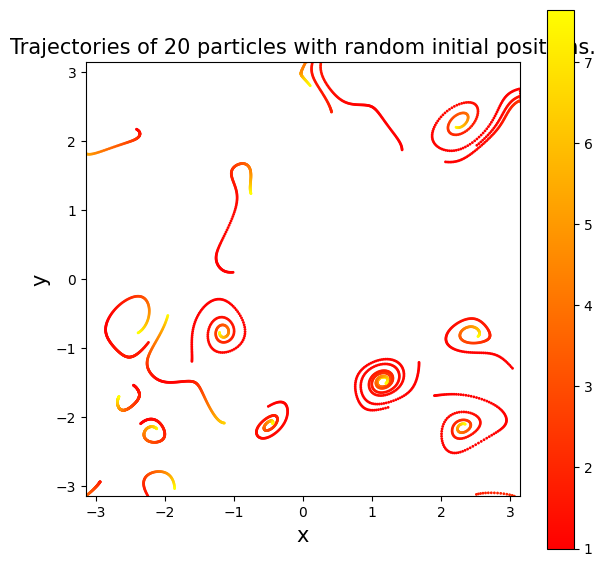

In [235]:
#Visualise the trajectories modulo the basin
fig,ax = plt.subplots(figsize=(7,7))


for sol in solutions:
  plt.scatter(sol[:,0],sol[:,1], c=sol[:,2], s=1, cmap='autumn')
  print(sol[:,2][-1])
  #print(sol)

#s = 15
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-np.pi, np.pi)
ax.set_xlabel('x',fontsize=s)
ax.set_ylabel('y',fontsize=s)
ax.set_title(f'Trajectories of {num_points} particles with random initial positions.',fontsize=s)
plt.gca().set_aspect('equal')
plt.colorbar()


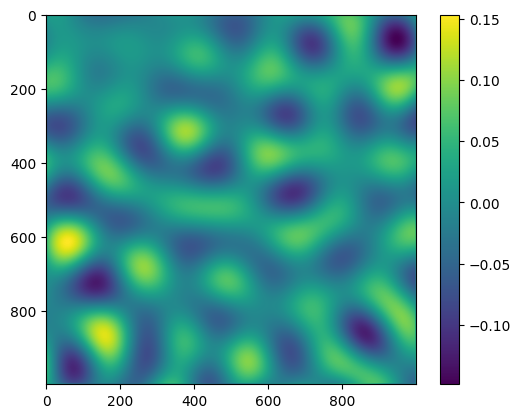

In [239]:
size_of_matrix = 101
Number_of_snapshots = 1 #and check every r days 
r=0
X = np.linspace(-np.pi, np.pi, size_of_matrix)
Y = np.linspace(-np.pi, np.pi, size_of_matrix)
psi = np.zeros((Number_of_snapshots, len(X), len(Y)), dtype = complex)
for a in range(Number_of_snapshots):
  for b in range(len(X)):
    for c in range(len(Y)):
      psi[a,b,c] = np.sum(A_vals*np.exp(1j*(K*X[b]+L*Y[c]-omega_vals*(a*r) + phi)))


PSI = np.zeros((Number_of_snapshots, len(X), len(Y)), dtype = complex)
for a in range(Number_of_snapshots):
  for b in range(len(X)):
    for c in range(len(Y)): 
      PSI[a,b,c] = np.real(streamfunction(0, (X[b], Y[c], 0)))

X, Y = np.linspace(-np.pi, np.pi, 1000), np.linspace(-np.pi, np.pi, 1000)
psi = np.empty((len(X),len(Y)))
for i,x in enumerate(X):
  for j,y in enumerate(Y):
    psi[i,j] = streamfunction(0,(x,y,1))

plt.imshow(np.real(psi), cmap='viridis')
#plt.imshow(np.real(psi[0]), cmap='viridis')
#plt.xlim(-np.pi, np.pi)
#plt.ylim(-np.pi, np.pi)

plt.gca().set_aspect('equal')
plt.colorbar()
#ticks = np.linspace(0, 60, 3)  # Adjust the number of ticks as needed
#tick_labels = [r'$-\pi$', '0',  r'$\pi$']
#plt.xticks(ticks, tick_labels)
#plt.yticks(ticks, tick_labels)

# Show the plot
plt.show() 

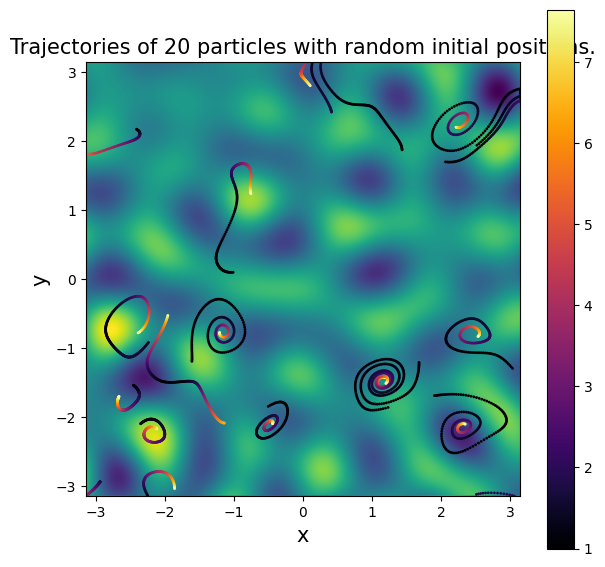

In [241]:

fig,ax = plt.subplots(figsize=(7,7))
extent = (-np.pi, np.pi, -np.pi, np.pi)
ax.imshow(np.real(psi), extent = extent, cmap='viridis')
#plt.xlim(-np.pi, np.pi)
#plt.ylim(-np.pi, np.pi)


for sol in solutions:
  plt.scatter(sol[:,0],sol[:,1], c=sol[:,2], s=1, cmap='inferno')


ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-np.pi, np.pi)
ax.set_xlabel('x',fontsize=s)
ax.set_ylabel('y',fontsize=s)
ax.set_title(f'Trajectories of {num_points} particles with random initial positions.',fontsize=s)
plt.gca().set_aspect('equal')
plt.colorbar()

# Show the plot
plt.show() 

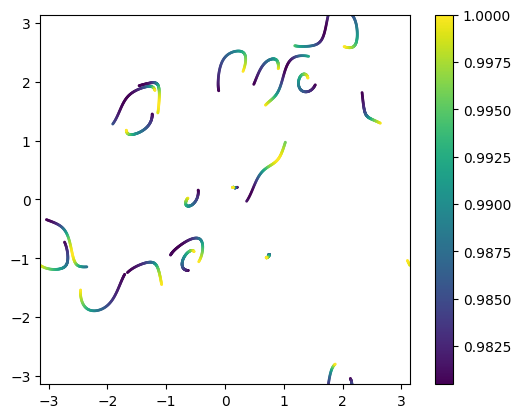

In [155]:
concentrations = np.ones((20, 1))
X=np.linspace(0, 2*np.pi, size_of_matrix)
Y=X
dt=1
num_steps=100
L=np.pi
velocity_field = psi
phase_field = psi
gamma = 0.1
path = integrate_particles(positions, concentrations, velocity_field, X, Y, dt, num_steps, L, phase_field, gamma, r)

scatters = []
fig, ax = plt.subplots()
for i in range(len(positions)):
    scatter = ax.scatter([path[j][i][0]-np.pi for j in range(num_steps+1)],[path[j][i][1]-np.pi for j in range(num_steps+1)], s=1, c=[path[j][i][2] for j in range(num_steps+1)])
    #print([path[j][i][2] for j in range(num_steps+1)][-1])
    scatters.append(scatter)
    
cbar = fig.colorbar(scatters[0], ax=ax)
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)

plt.gca().set_aspect('equal')
plt.show()